## Examples with JAX

In [1]:
import matplotlib.pyplot as plt

In [2]:
import jax
from jax import numpy as np
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize

In [4]:
import sys

sys.argv[1] = True
from Functions_hyper import load_data, minimizer, select_traintest, Hyper_minimizer

yes, JAX!


### Load data

In [5]:
path_directory = 'DATA/'
system_names = ['AAAA']

types={}

# experimental observables (average and uncertainty)
types['g_exp'] = {}
for name in system_names:
    types['g_exp'][name] = ['backbone1_gamma_3J','backbone2_beta_epsilon_3J','sugar_3J','NOEs']#,('uNOEs','<')]
    # types['g_exp'][name] = ['backbone1_gamma_3J']
    # types['g_exp'][name] = ['backbone2_beta_epsilon_3J']


# quantities needed to compute observables through forward model (from MD simulations)
types['forward_qs'] = {}
types['obs'] = {}
for name in system_names:
    types['forward_qs'][name] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']
    # types['forward_qs'][name] = ['backbone1_gamma']
    # types['forward_qs'][name] = ['backbone2_beta_epsilon']
    types['obs'][name] = ['NOEs']#,'uNOEs']

filename_forward_coeffs = 'original_coeffs'#_gamma'

# force-field correction terms (types['ff_terms'] must correspond to selected columns in corresponding pandas DataFrames)
types['ff_terms'] = {}
for name in system_names: types['ff_terms'][name] = ['sinalpha','cosalpha','sinzeta','coszeta']

stride = 100

In [6]:
def forward_model_splitted(fm_coeffs, forward_qs, *, selected_obs = None):
    
    forward_qs_out = {}
    derivatives = {}

    for name in forward_qs.keys():

        # you could do this just once before loading data, since you have always to compute the cosine
        forward_qs_cos = {}
        if selected_obs is None:
            for type_name in forward_qs[name].keys():
                forward_qs_cos[type_name] = np.cos(forward_qs[name][type_name])
        else:
            for type_name in forward_qs[name].keys():
                forward_qs_cos[type_name] = np.cos(forward_qs[name][type_name][:,selected_obs[name][type_name]])

        forward_qs_out[name] = {
            'backbone1_gamma_3J': fm_coeffs['A_gamma']*forward_qs_cos['backbone1_gamma']**2-fm_coeffs['B_gamma']*forward_qs_cos['backbone1_gamma']+fm_coeffs['C_gamma'],
            'backbone2_beta_epsilon_3J': fm_coeffs['A_beta']*forward_qs_cos['backbone2_beta_epsilon']**2-fm_coeffs['B_beta']*forward_qs_cos['backbone2_beta_epsilon']+fm_coeffs['C_beta'],
            'sugar_3J': fm_coeffs['A_sugar']*forward_qs_cos['sugar']**2-fm_coeffs['B_sugar']*forward_qs_cos['sugar']+fm_coeffs['C_sugar']}

        derivatives[name] = {
            'backbone1_gamma_3J': {
                'A_gamma': forward_qs_cos['backbone1_gamma']**2,
                'B_gamma': -forward_qs_cos['backbone1_gamma'],
                'C_gamma': np.ones(forward_qs_cos['backbone1_gamma'].shape)},
            'backbone2_beta_epsilon_3J': {
                'A_beta': forward_qs_cos['backbone2_beta_epsilon']**2,
                'B_beta': -forward_qs_cos['backbone2_beta_epsilon'],
                'C_beta': np.ones(forward_qs_cos['backbone2_beta_epsilon'].shape)},
            'sugar_3J': {
                'A_sugar': forward_qs_cos['sugar']**2,
                'B_sugar': -forward_qs_cos['sugar'],
                'C_sugar': np.ones(forward_qs_cos['sugar'].shape)}}

    return forward_qs_out,derivatives

In [7]:
data = load_data(path_directory, system_names, types, stride = stride, ff_correction = 'linear',
    forward_model = forward_model_splitted, filename_forward_coeffs = filename_forward_coeffs)

loading data from directory...
done


### gamma_function

0. define $\Gamma(\lambda,\alpha)$

In [8]:
from Functions_hyper import gamma_function

In [9]:
alpha = 1.0

In [10]:
name_sys = 'AAAA'

# x0 = np.float64(np.array(lambdas[js[i_sys][0]:js[i_sys][-1]]))#, order = 'K')

g = np.hstack([data.g[name_sys][k] for k in data.n_experiments[name_sys].keys()])
gexp = np.vstack([data.gexp[name_sys][k] for k in data.n_experiments[name_sys].keys()])
# normg_std = np.hstack([data.normg_std[name_sys][k] for k in data.n_experiments[name_sys].keys()])

weights = data.weights[name_sys]

In [11]:
key = jax.random.PRNGKey(140896)
x0 = jax.random.uniform(key, shape = (g.shape[1],))

In [52]:
jax.random.choice(key, np.arange(10),(4,), replace=True)

DeviceArray([4, 8, 9, 3], dtype=int64)

In [15]:
out = gamma_function(x0, g, gexp, weights, alpha, True)
out

(DeviceArray(-14.7577388, dtype=float64),
 DeviceArray([ 1.77304821e+00,  7.56861922e-01, -7.33762171e-01,
              -9.85241211e-01,  7.20233036e-01, -9.18948771e-01,
               7.25398510e-02, -4.15033243e-01,  2.39584836e-02,
               1.90865305e+00, -1.27563630e+01, -2.28018928e+00,
              -3.66082768e+00, -4.27731831e+00,  5.03324885e-01,
              -6.10009166e+00, -5.15821948e+00,  1.14251279e-01,
              -2.75219484e+00,  2.81642881e+00,  6.75129144e-01,
              -4.40723947e+00,  4.75732936e+00,  2.63712271e+00,
              -3.69561189e+00,  2.20571200e+00, -2.52966541e+00,
               7.33305451e+00, -1.11591163e-03,  1.75762663e-05,
               3.24370797e-04, -1.54906586e-03,  8.75547517e-05,
               8.54816242e-05,  5.59773914e-04,  9.11349466e-05,
               7.72155502e-04,  3.66509375e-04, -9.73743706e-04,
              -3.04188167e-03, -9.30539630e-06,  2.17176493e-04,
               4.30035803e-05, -7.26622531e-04, 

0a. compare gradient computed with Jax with mine 

In [16]:
gradient = jax.grad(gamma_function, argnums = 0)

In [17]:
gradient(x0, g, gexp, weights, alpha)

DeviceArray([ 1.77304821e+00,  7.56861922e-01, -7.33762171e-01,
             -9.85241211e-01,  7.20233036e-01, -9.18948771e-01,
              7.25398510e-02, -4.15033243e-01,  2.39584836e-02,
              1.90865305e+00, -1.27563630e+01, -2.28018928e+00,
             -3.66082768e+00, -4.27731831e+00,  5.03324885e-01,
             -6.10009166e+00, -5.15821948e+00,  1.14251279e-01,
             -2.75219484e+00,  2.81642881e+00,  6.75129144e-01,
             -4.40723947e+00,  4.75732936e+00,  2.63712271e+00,
             -3.69561189e+00,  2.20571200e+00, -2.52966541e+00,
              7.33305451e+00, -1.11591163e-03,  1.75762663e-05,
              3.24370797e-04, -1.54906586e-03,  8.75547517e-05,
              8.54816242e-05,  5.59773914e-04,  9.11349466e-05,
              7.72155502e-04,  3.66509375e-04, -9.73743706e-04,
             -3.04188167e-03, -9.30539630e-06,  2.17176493e-04,
              4.30035803e-05, -7.26622531e-04,  3.89851559e-05,
              1.68393800e-04,  5.9171043

In [37]:
out = gamma_function(x0, g, gexp, data.weights[name_sys], alpha, True)
out[1]

DeviceArray([ 1.77304821e+00,  7.56861922e-01, -7.33762171e-01,
             -9.85241211e-01,  7.20233036e-01, -9.18948771e-01,
              7.25398510e-02, -4.15033243e-01,  2.39584836e-02,
              1.90865305e+00, -1.27563630e+01, -2.28018928e+00,
             -3.66082768e+00, -4.27731831e+00,  5.03324885e-01,
             -6.10009166e+00, -5.15821948e+00,  1.14251279e-01,
             -2.75219484e+00,  2.81642881e+00,  6.75129144e-01,
             -4.40723947e+00,  4.75732936e+00,  2.63712271e+00,
             -3.69561189e+00,  2.20571200e+00, -2.52966541e+00,
              7.33305451e+00, -1.11591163e-03,  1.75762663e-05,
              3.24370797e-04, -1.54906586e-03,  8.75547517e-05,
              8.54816242e-05,  5.59773914e-04,  9.11349466e-05,
              7.72155502e-04,  3.66509375e-04, -9.73743706e-04,
             -3.04188167e-03, -9.30539630e-06,  2.17176493e-04,
              4.30035803e-05, -7.26622531e-04,  3.89851559e-05,
              1.68393800e-04,  5.9171043

In [38]:
hess1 = jax.jacfwd(jax.grad(gamma_function, argnums = 0), argnums = 0)
hess1(x0, g, gexp, data.weights[name_sys], alpha)

DeviceArray([[ 4.62169719e+00, -1.78213395e+00,  4.67444631e-02, ...,
              -4.51959344e-03,  2.34767828e-05,  9.28064577e-04],
             [-1.78213395e+00,  4.34589974e+00,  4.37708986e-01, ...,
               2.98974509e-03, -2.13199694e-05, -9.60039719e-05],
             [ 4.67444631e-02,  4.37708986e-01,  5.25387976e+00, ...,
               2.50980197e-03, -1.02278363e-05,  7.72213773e-04],
             ...,
             [-4.51959344e-03,  2.98974509e-03,  2.50980197e-03, ...,
               3.09269516e-05, -9.45224896e-08, -5.26861786e-06],
             [ 2.34767828e-05, -2.13199694e-05, -1.02278363e-05, ...,
              -9.45224896e-08,  8.44459883e-09,  1.34671737e-09],
             [ 9.28064577e-04, -9.60039719e-05,  7.72213773e-04, ...,
              -5.26861786e-06,  1.34671737e-09,  2.60419591e-06]],            dtype=float64)

In [39]:
hess2 = jax.hessian(gamma_function, argnums = 0)

hess2(x0, g, gexp, data.weights[name_sys], alpha)

DeviceArray([[ 4.62169719e+00, -1.78213395e+00,  4.67444631e-02, ...,
              -4.51959344e-03,  2.34767828e-05,  9.28064577e-04],
             [-1.78213395e+00,  4.34589974e+00,  4.37708986e-01, ...,
               2.98974509e-03, -2.13199694e-05, -9.60039719e-05],
             [ 4.67444631e-02,  4.37708986e-01,  5.25387976e+00, ...,
               2.50980197e-03, -1.02278363e-05,  7.72213773e-04],
             ...,
             [-4.51959344e-03,  2.98974509e-03,  2.50980197e-03, ...,
               3.09269516e-05, -9.45224896e-08, -5.26861786e-06],
             [ 2.34767828e-05, -2.13199694e-05, -1.02278363e-05, ...,
              -9.45224896e-08,  8.44459883e-09,  1.34671737e-09],
             [ 9.28064577e-04, -9.60039719e-05,  7.72213773e-04, ...,
              -5.26861786e-06,  1.34671737e-09,  2.60419591e-06]],            dtype=float64)

In [38]:
d2Gamma_dalpha_dlambda = jax.jacfwd(gradient, argnums = 4)

alpha = 1.0

d2Gamma_dalpha_dlambda(x0, g, gexp, data.weights[name_sys], alpha)

DeviceArray([1.79395980e+00, 2.08194619e+00, 1.17906734e+00,
             1.36519584e+00, 1.57233743e+00, 9.85162906e-01,
             1.35080529e+00, 1.20990463e+00, 1.07525084e+00,
             2.20307497e+00, 3.74778938e-02, 7.25456021e-01,
             1.87003456e+00, 2.10582521e+00, 1.34848245e+00,
             6.08667580e-01, 1.02029693e+00, 9.92873890e-01,
             1.63330956e+00, 1.18743135e+00, 9.20573703e-01,
             2.13404333e-01, 1.77018232e+00, 1.90060444e+00,
             2.20948298e-01, 5.48656822e-01, 6.25798097e-01,
             2.13425659e+00, 1.78976243e-07, 4.87541046e-10,
             2.56425120e-08, 2.78043145e-10, 1.47031895e-09,
             3.24659832e-09, 5.84692280e-08, 9.45937383e-09,
             7.82332861e-07, 1.26245466e-07, 3.01742539e-07,
             1.03453312e-07, 1.06671700e-09, 3.35734047e-08,
             3.04103284e-09, 1.42777345e-08, 7.46504547e-10,
             3.52622948e-09, 2.75105215e-07, 1.24181514e-06,
             1.40547561e

to be evaluated in the point of minimum of $\Gamma(\lambda, \alpha)$

In [39]:
vec = d2Gamma_dalpha_dlambda(x0, g, gexp, weights, alpha)
Hess = hess2(x0, g, gexp, weights, alpha)

dlambda_dalpha = - np.matmul(np.linalg.inv(Hess), vec)

dlambda_dalpha

NameError: name 'hess2' is not defined

1. define $\lambda(\alpha)$ through minimization of $\Gamma$

In [12]:
jax_minimize(gamma_function, x0, args = (g, gexp, weights, alpha), method = 'BFGS')

gammaf:  Traced<ConcreteArray(-14.757738803259372)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(-14.7577388, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
gammaf:  Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
gammaf:  Traced<ShapedArray(float64[])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=4/0)>
gammaf:  Traced<ShapedArray(float64[])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=4/0)>


OptimizeResults(x=DeviceArray([ 1.71534275e-01,  4.73749224e-01,  7.54955349e-01,
              1.13593296e+00,  3.79520089e-01,  7.44299545e-01,
              8.52216241e-01,  5.46110182e-01,  1.15717134e+00,
              2.16126466e+00,  2.60945386e+00,  1.09507927e+00,
              2.64951193e+00,  2.61451981e+00,  9.96197183e-01,
              2.46815419e+00,  3.08374318e+00, -9.90074717e-02,
              1.79018479e+00, -1.24936394e-01,  7.63150832e-02,
              1.58121369e+00, -6.45987528e-01, -2.77508999e-01,
              1.26720453e+00, -6.55528869e-01, -5.62691452e-01,
             -6.24407259e-01,  2.99998750e+03,  6.51868578e+03,
             -2.22595916e+02,  2.21802260e+03, -1.13885562e+03,
             -1.73606022e+03,  1.24573664e+02, -1.04118655e+03,
              1.81179071e+02, -1.39376975e+02,  1.33787488e+03,
              2.38252464e+03,  2.41573838e+04, -3.08849289e+02,
             -3.68520178e+03,  4.66398129e+03, -2.12458833e+03,
              6.149576

In [53]:
def minimize_Gamma(alpha, x0, g, gexp, weights):
    mini_x = jax_minimize(gamma_function, x0, args = (g, gexp, weights, alpha), method = 'BFGS').x
    
    print(mini_x)
    return mini_x

2. define $\frac{d\lambda}{d\alpha}$

In [36]:
gradient = jax.jacfwd(minimize_Gamma, argnums = 0)

in this way gradient gives 0...

In [19]:
x = minimize_Gamma(alpha, x0, g, gexp, weights)

gradient(alpha, x, g, gexp, weights)

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

3. put together

In [37]:
def minimize_Gamma_with_grad(alpha0, x0, g, gexp, weights):
    x = minimize_Gamma(alpha0, x0, g, gexp, weights)
    g = gradient(alpha0, x0, g, gexp, weights)
    print(x,g)
    return x,g

In [38]:
minimize_Gamma_with_grad(alpha, x0, g, gexp, weights)

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

(DeviceArray([ 1.71534275e-01,  4.73749224e-01,  7.54955349e-01,
               1.13593296e+00,  3.79520089e-01,  7.44299545e-01,
               8.52216241e-01,  5.46110182e-01,  1.15717134e+00,
               2.16126466e+00,  2.60945386e+00,  1.09507927e+00,
               2.64951193e+00,  2.61451981e+00,  9.96197183e-01,
               2.46815419e+00,  3.08374318e+00, -9.90074717e-02,
               1.79018479e+00, -1.24936394e-01,  7.63150832e-02,
               1.58121369e+00, -6.45987528e-01, -2.77508999e-01,
               1.26720453e+00, -6.55528869e-01, -5.62691452e-01,
              -6.24407259e-01,  2.99998750e+03,  6.51868578e+03,
              -2.22595916e+02,  2.21802260e+03, -1.13885562e+03,
              -1.73606022e+03,  1.24573664e+02, -1.04118655e+03,
               1.81179071e+02, -1.39376975e+02,  1.33787488e+03,
               2.38252464e+03,  2.41573838e+04, -3.08849289e+02,
              -3.68520178e+03,  4.66398129e+03, -2.12458833e+03,
               6.14957641

In [16]:
mini_x = minimize_Gamma(alpha, x0, g, gexp, weights)

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

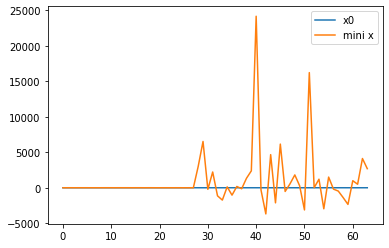

In [20]:
plt.plot(x0, label = 'x0')
plt.plot(mini_x, label = 'mini x')
plt.legend()

In [17]:
print(alpha, mini_x)

gradient(alpha, mini_x, g, gexp, weights)

1.0 [ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.9

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0.], dtype=float64)

In [18]:
minimize_Gamma_with_grad(alpha, x0, g, gexp, weights)

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

(DeviceArray([ 1.71534275e-01,  4.73749224e-01,  7.54955349e-01,
               1.13593296e+00,  3.79520089e-01,  7.44299545e-01,
               8.52216241e-01,  5.46110182e-01,  1.15717134e+00,
               2.16126466e+00,  2.60945386e+00,  1.09507927e+00,
               2.64951193e+00,  2.61451981e+00,  9.96197183e-01,
               2.46815419e+00,  3.08374318e+00, -9.90074717e-02,
               1.79018479e+00, -1.24936394e-01,  7.63150832e-02,
               1.58121369e+00, -6.45987528e-01, -2.77508999e-01,
               1.26720453e+00, -6.55528869e-01, -5.62691452e-01,
              -6.24407259e-01,  2.99998750e+03,  6.51868578e+03,
              -2.22595916e+02,  2.21802260e+03, -1.13885562e+03,
              -1.73606022e+03,  1.24573664e+02, -1.04118655e+03,
               1.81179071e+02, -1.39376975e+02,  1.33787488e+03,
               2.38252464e+03,  2.41573838e+04, -3.08849289e+02,
              -3.68520178e+03,  4.66398129e+03, -2.12458833e+03,
               6.14957641

4. compare with implicit function theorem

In [39]:
mini_x = minimize_Gamma(alpha, x0, g, gexp, weights)

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

In [40]:
gradient = jax.grad(gamma_function, argnums = 0)
hess = jax.hessian(gamma_function, argnums = 0)
# equivalently: jax.jacfwd(jax.grad(gamma_function, argnums = 0), argnums = 0)

d2Gamma_dalpha_dlambda = jax.jacfwd(gradient, argnums = 4)

In [41]:
vec = d2Gamma_dalpha_dlambda(mini_x, g, gexp, data.weights[name_sys], alpha)
Hess = hess(mini_x, g, gexp, data.weights[name_sys], alpha)

dlambda_dalpha = - np.matmul(np.linalg.inv(Hess), vec)

dlambda_dalpha

DeviceArray([-1.30519993e-01, -4.88615274e-01, -7.69171427e-01,
             -1.14687573e+00, -3.30220624e-01, -7.53059863e-01,
             -8.68330437e-01, -5.39429285e-01, -1.11354436e+00,
             -2.12316113e+00, -2.55353983e+00, -1.07685798e+00,
             -2.64641425e+00, -2.57687746e+00, -1.03076799e+00,
             -2.47765080e+00, -3.09742244e+00,  1.04659517e-01,
             -1.78845941e+00,  1.48175946e-01, -1.14541154e-01,
             -1.57050410e+00,  6.61867832e-01,  3.04426345e-01,
             -1.23757664e+00,  6.15615798e-01,  5.60033799e-01,
              6.48977051e-01, -2.90353365e+03, -7.71790455e+03,
              1.78492039e+02, -2.14695108e+03,  1.12616579e+03,
              1.78609140e+03, -8.33473422e+00,  4.67090231e+02,
             -2.51125204e+02,  6.55318360e+01, -1.36429604e+03,
             -2.43546288e+03, -2.54654573e+04,  4.38954962e+02,
              3.76070887e+03, -4.67389451e+03,  2.29394309e+03,
             -6.30941568e+03,  4.3002507

In [42]:
out = minimize_Gamma_with_grad(alpha, mini_x, g, gexp, weights)

out[1]

[ 1.71534275e-01  4.73749224e-01  7.54955349e-01  1.13593296e+00
  3.79520089e-01  7.44299545e-01  8.52216241e-01  5.46110182e-01
  1.15717134e+00  2.16126466e+00  2.60945386e+00  1.09507927e+00
  2.64951193e+00  2.61451981e+00  9.96197183e-01  2.46815419e+00
  3.08374318e+00 -9.90074717e-02  1.79018479e+00 -1.24936394e-01
  7.63150832e-02  1.58121369e+00 -6.45987528e-01 -2.77508999e-01
  1.26720453e+00 -6.55528869e-01 -5.62691452e-01 -6.24407259e-01
  2.99998750e+03  6.51868578e+03 -2.22595916e+02  2.21802260e+03
 -1.13885562e+03 -1.73606022e+03  1.24573664e+02 -1.04118655e+03
  1.81179071e+02 -1.39376975e+02  1.33787488e+03  2.38252464e+03
  2.41573838e+04 -3.08849289e+02 -3.68520178e+03  4.66398129e+03
 -2.12458833e+03  6.14957641e+03 -5.21390574e+02  5.46280593e+02
  1.80648878e+03  2.71728833e+02 -3.12323261e+03  1.62183726e+04
  5.20975110e+00  1.20565660e+03 -2.96346907e+03  1.50245783e+03
 -1.91793119e+02 -4.69824071e+02 -1.37848573e+03 -2.34625942e+03
  9.92480262e+02  4.95409

ValueError: matmul input operand 1 must have ndim at least 1, but it has ndim 0

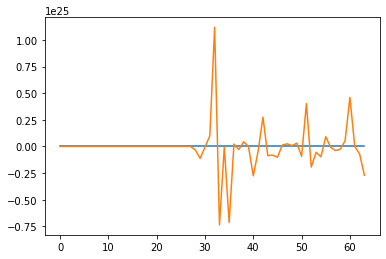

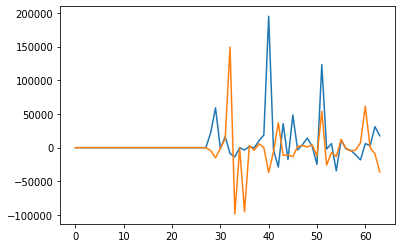

In [69]:
plt.plot(dlambda_dalpha)
plt.plot(out[1])


plt.figure()
plt.plot(dlambda_dalpha/dlambda_dalpha[0])
plt.plot(out[1]/out[1][0])

### implicit functions?
now, let's see if we can directly minimize implicit functions defined as the minimum of another function

see also http://implicit-layers-tutorial.org/implicit_functions/

- **my_func** $F(\vec x,\alpha)$ defines an implicit function **min_x** $\vec x = \vec f(\alpha)$ through $\vec \nabla_x F(\vec x,\alpha)=0$, which is the condition satisfied by $\vec x = \arg \min_{\vec x} F(\vec x,\alpha)$;
- can we compute $\frac{\partial\vec x}{\partial \alpha}$ directly through automatic differentiation on $\alpha$ or do we have to use the implicit function theorem?

0. define $f(x,\alpha)$

In [21]:
func = lambda x, alpha, beta: 1/2*(alpha[0]*x[0])**2 - x[0]*alpha[0]**4 + alpha[0]

1. define $x(\alpha) = \arg\min_x f(x, \alpha)$

In [22]:
def minimize_x(alpha, x0, beta):
    # mini = minimize(my_func_with_grad, x0, args = (alpha, None), method = 'BFGS', jac = True)
    mini_x = jax_minimize(func, x0, args = (alpha, None), method = 'BFGS').x

    # gradient = jax.jacfwd(mini_x, argnums = 1)
    # grad = gradient(x0, alpha, beta)

    print(mini_x)
    return mini_x

2. define $\frac{d x}{d \alpha}$

In [23]:
# print(minimize_x(alpha, x0, None))

gradient = jax.jacfwd(minimize_x, argnums = 0)
# gradient(alpha, x0, None)

In [24]:
alpha0 = np.array([2.2])
x0 = np.array([0.1])

print(minimize_x(alpha0, x0, None))

print(gradient(alpha0, x0, None))

[4.84]
[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0
[[4.4]]


in this way gradient gives 0, why?

In [25]:
x = minimize_x(alpha0, x0, None)

gradient(alpha0, x, None)

[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0


DeviceArray([[0.]], dtype=float64)

3. put $(x, \frac{dx}{d\alpha})$ in the same Python function

In [10]:
def minimize_x_with_grad(alpha0, x0, beta):
    x = minimize_x(alpha0, x0, None)
    g = gradient(alpha0, x0, None)
    print(x,g)
    return x,g

In [11]:
out = minimize_x_with_grad(alpha0, x0, None)

[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0
[4.84] [[4.4]]


(DeviceArray([4.84], dtype=float64), DeviceArray([[4.4]], dtype=float64))

4. compare $\frac{dx}{d\alpha}$ (computed by jax directly on $x(\alpha)$) with implicit function theorem $\frac{dx}{d\alpha} = -\Bigl(\frac{\partial^2 f}{\partial x^2}\Bigr)^{-1} \frac{\partial^2 f}{\partial x \partial\alpha}$

(remember to evaluate $\frac{\partial^2 f}{\partial x^2}$ and $\frac{\partial^2 f}{\partial x \partial \alpha}$ in $x=x(\alpha)$)

In [22]:
Hess = jax.hessian(func, argnums = 0)
mix_grad = jax.jacfwd((jax.grad(func, argnums = 0)), argnums = 1)
# mix_grad2 = jax.jacfwd((jax.grad(func, argnums = 1)), argnums = 0)

In [24]:
x = minimize_x_with_grad(alpha0, x0, None)[0]
print(x)

h = Hess(x, alpha0, None)
v = mix_grad(x, alpha0, None)
# v2 = mix_grad2(x0, alpha0, None)

print(h, v)

print(-v/h)

[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0
[4.84] [[4.4]]
[4.84]
[[4.84]] [[-21.296]]
[[4.4]]


Yes, we can! B. O.

#### let's use jax only to compute the gradient, and then usual scipy

In [6]:
def my_func_with_grad(x,alpha,beta):
    
    f = func(x, alpha, beta)
    
    # func = lambda x, alpha: 1/2*(alpha[0]*x[0])**2 - x[0]*alpha[0]**4 + alpha[0]
    df_dx = jax.grad(func, argnums = 0)
    # f = np.float64(f)
    
    grad = df_dx(x, alpha, None)
    print('x, alpha, f, grad:',x,alpha,f,grad)
    return f, grad

In [12]:
alpha = np.array([1.5])
x0 = np.array([0.01])

print(my_func_with_grad(x0, alpha, None))

print('minimize:')
minimize(my_func_with_grad, x0, args = (alpha, None), method = 'BFGS', jac = True)

x, alpha, f, grad: [0.01] [1.5] 1.4494875 [-5.04]
(DeviceArray(1.4494875, dtype=float64), DeviceArray([-5.04], dtype=float64))
minimize:
x, alpha, f, grad: [0.01] [1.5] 1.4494875 [-5.04]
x, alpha, f, grad: [1.02] [1.5] -2.4933000000000005 [-2.7675]
x, alpha, f, grad: [2.25] [1.5] -4.1953125 [0.]


      fun: -4.1953125
 hess_inv: array([[0.44444444]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([2.25])

In [8]:
def min_x_with_grad(alpha, x0, beta):
    
    minimize_x = lambda x0, alpha: minimize(my_func_with_grad, x0, args = (alpha, None), method = 'BFGS', jac = True).x
    min_x = minimize_x(x0, alpha)

    dx_dalpha = jax.jacrev(minimize_x, argnums = 1)

    grad = dx_dalpha(x0, alpha)

    print(min_x, grad)
    
    return min_x, grad

In [9]:
min_x_with_grad(alpha, x0, None)

x, alpha, f, grad: [0.01] [2.] 1.8402 [-15.96]
x, alpha, f, grad: [1.02] [2.] -12.239199999999997 [-11.92]
x, alpha, f, grad: [3.40593859] [2.] -29.294182083732935 [-2.37624564]
x, alpha, f, grad: [4.] [2.] -30.0 [0.]
x, alpha, f, grad: [0.01] Traced<ConcreteArray([2.])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([2.]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> Traced<ConcreteArray(1.8402)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(1.8402, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)> Traced<ConcreteArray([-15.96])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-15.96], dtype=float64)
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([-15.96])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-15.96], dtype=float64)
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [5]:
def minimize_x(alpha, x0, beta):
    # mini = minimize(my_func_with_grad, x0, args = (alpha, None), method = 'BFGS', jac = True)
    mini_x = jax_minimize(func, x0, args = (alpha, None), method = 'BFGS').x

    # gradient = jax.jacfwd(mini_x, argnums = 1)
    # grad = gradient(x0, alpha, beta)

    print(mini_x)
    return mini_x

In [6]:
# print(minimize_x(alpha, x0, None))

gradient = jax.jacfwd(minimize_x, argnums = 0)
# gradient(alpha, x0, None)

In [13]:
alpha0 = np.array([2.2])
x0 = np.array([0.1])

gradient(alpha0, x0, None)

Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0


DeviceArray([[4.4]], dtype=float64)

In [19]:
print(alpha0)
x = minimize_x(alpha0, x0, None)
print(x)

print(gradient(alpha0, x0, None))

print(gradient(alpha0, x, None))

[2.2]
[4.84]
[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0
[[4.4]]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[[0.]]


In [8]:
alpha0 = np.array([2.2])

jax_minimize(minimize_x, alpha0, args = (x0, None), method = 'BFGS')

Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>


TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [20]:
def minimize_x_with_grad(alpha, x0, beta):
    x = minimize_x(alpha, x0, None)
    # gradient = jax.jacfwd(minimize_x, argnums = 0)
    grad = gradient(alpha, x0, None)#[0]
    print(grad)
    return x, grad

In [21]:
minimize_x_with_grad(alpha0, x0, None)

[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[4.4]], dtype=float64)
                        batch_dim = 0
[[4.4]]


(DeviceArray([4.84], dtype=float64), DeviceArray([[4.4]], dtype=float64))

In [29]:
alpha = alpha0
print(alpha0, x0, alpha)

x = minimize_x(alpha0, x0, None)
print(x)

gradient = jax.jacfwd(minimize_x, argnums = 0)

alpha = np.array([2.2])
grad = gradient(alpha, x, None)[0]
print('grad: ',grad)

[2.2] [0.01] [2.2]
[4.84]
[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
grad:  [0.]


In [35]:
grad = gradient(np.array([2.2]), x, None)[0]
grad

Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0


DeviceArray([0.], dtype=float64)

Traced<ConcreteArray([27.04])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([27.04], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[-10.4]], dtype=float64)
                        batch_dim = 0
Traced<ConcreteArray([17.64])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([17.64], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[-8.4]], dtype=float64)
                        batch_dim = 0
Traced<ConcreteArray([10.24])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([10.24], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[-6.4]], dtype=float64)
                        batch_dim = 0
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<Sh

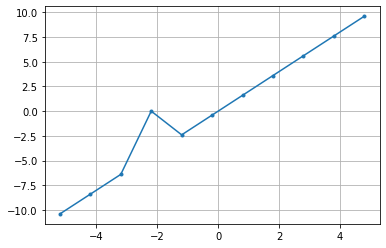

In [36]:
alphas = np.arange(-5.2,5.2,1.0)

my_list = []
for alpha in alphas:
    my_list.append(gradient(np.array([alpha]), x, None)[0])

plt.plot(alphas, my_list,'.-')
plt.grid()

In [18]:
minimize_x_with_grad(alpha, x0, None)

[2.25]
Traced<ConcreteArray([2.25])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([2.25], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]


(DeviceArray([2.25], dtype=float64), DeviceArray([0.], dtype=float64))

In [16]:
minimize(minimize_x_with_grad, alpha0, args = (x0, None), method = 'BFGS', jac = True)

[4.84]
Traced<ConcreteArray([4.84])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.84], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]


      fun: 4.840000000000001
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.2])

In [55]:
x = minimize_x(alpha, x0, None)
# gradient = jax.grad(minimize_x, argnums = 0)
gradient = jax.jacfwd(minimize_x, argnums = 0)

gradient(alpha, x, None)

[16.]
Traced<ConcreteArray([16.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([16.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0


DeviceArray([[0.]], dtype=float64)

In [51]:
alpha = np.array([4.0])
minimize_x_with_grad(alpha, x0, None)

[16.]
Traced<ConcreteArray([16.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([16.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]


(DeviceArray([16.], dtype=float64), DeviceArray([0.], dtype=float64))

[25.]
Traced<ConcreteArray([25.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([25.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]
[20.25]
Traced<ConcreteArray([20.25])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([20.25], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]
[16.]
Traced<ConcreteArray([16.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([16.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]
[12.25]
Traced<ConcreteArray([12.25])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([12.25], dtype=float

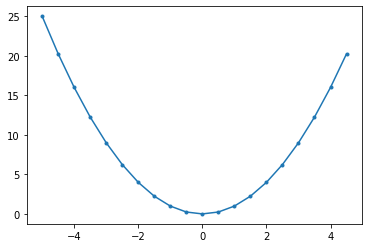

In [48]:
alphas = np.arange(-5,5,0.5)

xs = []
for alpha in alphas:
    xs.append(minimize_x_with_grad(np.array([alpha]), x0, None)[0])

plt.plot(alphas,xs,'.-')

In [45]:
mini = minimize(minimize_x_with_grad, alpha, args =(x0, None), method = 'BFGS', jac = True)

[4.]
Traced<ConcreteArray([4.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([4.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([[0.]], dtype=float64)
                        batch_dim = 0
[0.]


In [46]:
mini

      fun: 4.0
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.])

In [16]:
minimize(minimize_x, alpha, args =(x0, None), method = 'BFGS', jac = True)

KeyboardInterrupt: 

In [10]:
def my_func(x,alpha,beta):
    f = func(x, alpha)#1/2*(alpha[0]*x[0])**2 - x[0]*alpha[0]**4 + alpha[0]
    # f = np.float64(f)
    print('x, alpha, f:',x,alpha,f)
    return f

In [11]:
df_dx = jax.grad(my_func, argnums = 0)

In [21]:
x0 = np.array([0.1])
alpha = np.array([2.0])

df_dx(x0, alpha, None)

x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [2.] Traced<ConcreteArray(0.41999999999999993)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(0.42, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>


DeviceArray([-15.6], dtype=float64)

In [32]:
def min_x_func(alpha, beta):
    mini = jax_minimize(my_func, x0, args = (alpha, beta), method = 'BFGS')#, options = {'gtol': 1e-3})
    min_x = mini.x[0]
    return min_x

In [34]:
x = min_x_func(np.array([0.01]),None)

x, alpha, f: Traced<ConcreteArray([0.01])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.01]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [0.01] Traced<ConcreteArray(0.0100000049)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(0.01, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [0.01] Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>
       tangent = Traced<ShapedArray(float

[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01]
x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [-1.] Traced<ConcreteArray(-1.095)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(-1.095, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [-1.] Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal 

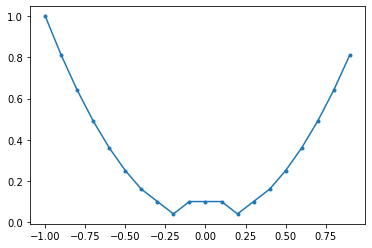

In [9]:
alphas = np.arange(-1,1,0.1)
print(alphas)

my_list = []
for alpha in alphas:
    f = min_x_func(np.array([alpha]),None)
    print(alpha, f)
    my_list.append(f)

plt.plot(alphas, my_list, '.-')

In [153]:
dx_dalpha = jax.jacfwd(min_x_func, argnums = 0)
# gradient = jax.grad(min_x_func, argnums = 0)
# gradient = jax.jacrev(min_x_func, argnums = 0)

In [154]:
dx_dalpha(np.array([1.0]),None)

x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> Traced<ConcreteArray([1.])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([1.], dtype=float64)
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = array([[1.]])
                        batch_dim = 0 Traced<ConcreteArray(0.905)>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray(0.905)>with<JVPTrace(level=2/0)>
                  with primal = DeviceArray(0.905, dtype=float64)
                       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                                   with val = DeviceArray([0.61], dtype=float64)
                                        batch_dim = 0
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<

DeviceArray([3.8], dtype=float64)

In [40]:
def min_x_func_with_grad(alpha, beta):
    x = min_x_func(alpha, beta)

    dx_dalpha = jax.jacfwd(min_x_func, argnums = 0)
    grad = dx_dalpha(alpha, beta)

    print('alpha, grad: ',alpha,grad)
    return x, grad

In [ ]:
def min_x_func_with_grad(alpha, beta):
    mini = minimize(min_x_func_with_grad(alpha, beta))
    

    dx_dalpha = jax.jacfwd(min_x_func, argnums = 0)
    grad = dx_dalpha(alpha, beta)

    print('alpha, grad: ',alpha,grad)
    return x, grad

In [41]:
mini = minimize(min_x_func_with_grad, alpha, args = (None), method = 'BFGS', jac = True, options =  {'gtol': 1e-3})

x, alpha, f: Traced<ConcreteArray([0.01])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.01]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [2.] Traced<ConcreteArray(1.8402)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(1.8402, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [2.] Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>
       tangent = Traced<ShapedArray(float64[1]):J

In [42]:
mini

      fun: 0.01
 hess_inv: array([[0.5]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.])

In [152]:
x = mini.x
print(x)

print(mini.fun)

min_x_func_with_grad(x,None)

[-2.22044605e-16]
0.1
x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [-2.22044605e-16] Traced<ConcreteArray(-2.220446049250313e-16)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(-2.22044605e-16, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [-2.22044605e-16] Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[1]):J

(DeviceArray(0.1, dtype=float64), DeviceArray([0.], dtype=float64))

#### ...

In [113]:
def my_func(x,alpha,beta):
    f = 1/2*(alpha[0]*x[0])**2 - x[0]*alpha[0]**4 + alpha[0]
    f = np.float64(f)
    print('x, alpha, f:',x,alpha,f)
    return f

In [114]:
from jax.scipy.optimize import minimize
# from scipy.optimize import minimize

In [115]:
x0 = np.array([0.1])
alpha = np.array([2.0])

beta = None
gamma = None

def min_x(alpha, beta, gamma):
    beta = None
    mini = minimize(my_func, x0, args = (alpha, beta), method = 'BFGS', options = {'gtol': 1e-3})
    min_x = mini.x[0]
    return min_x

In [116]:
min_x(alpha,beta,gamma)

x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)> [2.] Traced<ConcreteArray(0.41999999999999993)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(0.42, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [2.] Traced<ShapedArray(float64[])>with<JVPTrace(level=4/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=5/0)>
  with primal = Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>
       tangent = Traced<ShapedArray(floa

DeviceArray(4., dtype=float64)

In [59]:
alpha0 = np.array([2.0])
gamma = None

minimize(min_x, alpha0, args = (beta, gamma), method = 'BFGS', options = {'gtol': 1e-3, 'maxiter': 10})

Traced<ConcreteArray(3.62)>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray(3.62)>with<JVPTrace(level=2/0)>
                  with primal = DeviceArray(3.62, dtype=float64)
                       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
Traced<ShapedArray(float64[])>with<JVPTrace(level=6/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=4/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=5/0)>
Traced<ShapedArray(float64[])>with<JVPTrace(level=7/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=5/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=6/0)>
Traced<ShapedArray(float64[])>with<JVPTrace(level=7/0)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=5/0)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=6/0)>


ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop. Try using lax.scan instead.

it seems that jax is not able to differentiate if the n. of loops is not fixed...

In [63]:
gradient = jax.grad(my_func, argnums = 0)
gradient([1.0],[1.0],None)

Traced<ConcreteArray(2.5)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(2.5, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>


[DeviceArray(2., dtype=float64)]

In [64]:
Hess = jax.hessian(my_func)

Hess([1.0],[1.0],None)

Traced<ConcreteArray(2.5)>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray(2.5)>with<JVPTrace(level=2/0)>
                  with primal = DeviceArray(2.5, dtype=float64)
                       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                                   with val = DeviceArray([2.], dtype=float64)
                                        batch_dim = 0
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>


[[DeviceArray(1., dtype=float64)]]

In [117]:
Hessian = jax.jacfwd(gradient, argnums = 0)
Hessian([1.0],[1.0],None)

TypeError: min_x_func() takes 2 positional arguments but 3 were given

jax is able to compute the derivative of the implicit function!!

In [118]:
alpha = np.array([1.0])
# np.gradient(min_x, argnums = 0)
gradient = jax.jacfwd(min_x, argnums = 0)

print(gradient([1.0],None,None))

x, alpha, f: Traced<ConcreteArray([0.1])>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray([0.1]):JaxprTrace(level=3/0)>
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=3/0)> [Traced<ConcreteArray(1.0, weak_type=True)>with<JVPTrace(level=2/0)>
  with primal = 1.0
       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                   with val = array([1.])
                        batch_dim = 0] Traced<ConcreteArray(0.905)>with<JVPTrace(level=4/0)>
  with primal = Traced<ConcreteArray(0.905)>with<JVPTrace(level=2/0)>
                  with primal = DeviceArray(0.905, dtype=float64)
                       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                                   with val = DeviceArray([0.61], dtype=float64)
                                        batch_dim = 0
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/0)>
x, alpha, f: Traced<ShapedArray(float64[1])>with<JVPTrace(level=

In [86]:
from scipy.optimize import minimize

In [84]:
def min_x_with_grad(alpha, beta = None, gamma = None):
    x = min_x(alpha, beta, gamma)
    grad = gradient(alpha, beta, gamma)
    return x, grad

In [87]:
minimize(min_x_with_grad, alpha0, args = (beta, gamma), method = 'BFGS', jac = True, options = {'gtol': 1e-3, 'maxiter': 10})

x, alpha, f: [0.1] [2.] 3.62
x, alpha, f: [0.10000001] [2.] 3.620000244379044
x, alpha, f: [-0.91] [2.] -10.9038
x, alpha, f: [-0.90999999] [2.] -10.903799815821648
x, alpha, f: [-3.28363074] [2.] -28.973630171208484
x, alpha, f: [-3.28363073] [2.] -28.97363012850955
x, alpha, f: [-3.99999994] [2.] -29.999999999999993
x, alpha, f: [-3.99999992] [2.] -29.99999999999999
x, alpha, f: [0.1] Traced<ConcreteArray([2.])>with<JVPTrace(level=2/0)>
  with primal = array([2.])
       tangent = Traced<ShapedArray(float64[1])>with<BatchTrace(level=1/0)>
                   with val = array([[1.]])
                        batch_dim = 0 Traced<ConcreteArray(3.62)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(3.62, dtype=float64)
       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([4.22], dtype=float64)
                        batch_dim = 0


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray(3.62)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(3.62, dtype=float64)
       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([4.22], dtype=float64)
                        batch_dim = 0
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

compute directly the Hessian

In [ ]:
def my_func(lambdas, alpha):
    A = np.identity(len(lambdas))*alpha
    b = np.ones(len(lambdas))*alpha
    f = np.einsum('i,ij,j',lambdas,A,lambdas)+np.dot(b,lambdas)
    
    return f

In [ ]:
key = jax.random.PRNGKey(140896)

lambdas = jax.random.uniform(key, shape = (5,))
lambdas

DeviceArray([0.82396566, 0.47126652, 0.54341763, 0.81843911, 0.30040287],            dtype=float64)

In [ ]:
gradient = grad(my_func,argnums=0)

alpha = 2.0

gradient(lambdas,alpha)

DeviceArray([5.29586264, 3.88506607, 4.1736705 , 5.27375644, 3.20161148],            dtype=float64)

In [ ]:
d2f_dxdy = grad(gradient, argnums = 1)

d2f_dxdy(lambdas,alpha)


TypeError: Gradient only defined for scalar-output functions. Output had shape: (5,).

In [ ]:
Hess = hessian(my_func,argnums = 0)

my_hessian = Hess(lambdas, alpha)

Hess_inv = np.linalg.inv(my_hessian)
np.einsum(Hess_inv,)

DeviceArray([[4., 0., 0., 0., 0.],
             [0., 4., 0., 0., 0.],
             [0., 0., 4., 0., 0.],
             [0., 0., 0., 4., 0.],
             [0., 0., 0., 0., 4.]], dtype=float64)